# <center>Titanic - Machine Learning from Disaster</center>
===========================================================================================================================================
<p align="right">王鑫轶 大数据2001</p>
<p align="right">黄静淼 大数据2001</p>

## 数据预处理

### 导入相关库

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,LeaveOneOut
import warnings
warnings.filterwarnings("ignore")

### 数据获取
了解数据的基本信息

In [87]:
path='titanic/'
test_data=pd.read_csv(path+'test.csv')  # 读取数据
train_data=pd.read_csv(path+'train.csv')# 读取数据
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


|列名|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
|---|------------|--------|------|----|---|---|-----|-----|------|----|-----|--------|
|意义|乘客编号|乘客是否存活|顾客的舱位等级|姓名|性别|年龄|乘客的兄弟姐妹或配偶在船上的人数|乘客的父母儿子在船上的人数|乘客票的编号|乘客在船上的消费|乘客舱位的编号|乘客上船的地点|

Ticket 列为票的编号，其中的数据杂乱，且对我们着次分析来说没有意义。所以将 Ticket 列的数据从数据集中删除。

此外，我认为乘客的姓名对是否存活无影响，所以将改列的数据删除。

还有 PassengerId 列对分析并没有实际意义，所以删除该列。

In [88]:
train_data.drop(labels=['Name','Ticket','PassengerId'],inplace=True,axis=1) # 删除 'Name','Ticket','PassengerId' 列
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


观察 Sibsp 和 Parch 两列发现,他们的意义相近，可以进行简单的相加

In [89]:
train_data['Family'] = train_data.SibSp+train_data.Parch
train_data.drop(labels=['SibSp','Parch'],inplace=True,axis=1)

### 缺失值处理

In [90]:
train_data.info() # 查看信息
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      891 non-null    float64
 5   Cabin     204 non-null    object 
 6   Embarked  889 non-null    object 
 7   Family    891 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,0,3,male,22.0,7.2500,NaN,S,1
1,1,1,female,38.0,71.2833,C85,C,1
2,1,3,female,26.0,7.9250,NaN,S,0
3,1,1,female,35.0,53.1000,C123,S,1
4,0,3,male,35.0,8.0500,NaN,S,0


由上面可以看出 Age、Cabin、Embarked 列有的缺失值，且Cabin 列的缺失值过多，因此将 Cabin 列进行删除操做。

之后对 int 类型的 Age 列的缺失值以其平均值填充，对 object 类型的 Embarked 列的缺失值以其众数填充。

In [91]:
train_data.drop(labels='Cabin',inplace=True,axis=1)# 删除 Cabin 列
train_data['Age']=train_data['Age'].fillna(29.70) # 29.70 为 Age 列的均值。
train_data['Embarked']=train_data['Embarked'].fillna(train_data.Embarked.mean) # 对 Age 和 Embarked 列进行平均值填充

### 数据标准和归一化

因为 sex、Embarked 列的数据为字符串类型，所以需要将其离散化处理，使其方便于模型训练。

In [92]:
def sexfun(s):# 性别转换函数
    if s=='male':
        return 1
    else:
        return 0

train_data.Sex = train_data.Sex.apply(sexfun) # 男性为 1，女性为 0。

def EmbarkedFun(s):# 上船地点转换函数
    if s=='S':
        return 0
    elif s=='C':
        return 1
    else:
        return 2

train_data.Embarked=train_data.Embarked.apply(EmbarkedFun) # 将 S 转换为 0，C 转换为 1，Q 转换为 2。

归一化：
- 把数据变成(０，１)或者（1,1）之间的小数。主要是为了数据处理方便提出来的，把数据映射到0～1范围之内处理，更加便捷快速。
- 把有量纲表达式变成无量纲表达式，便于不同单位或量级的指标能够进行比较和加权。归一化是一种简化计算的方式，即将有量纲的表达式，经过变换，化为无量纲的表达式，成为纯量。

这步，我们将 Fare 列和 Age 列的数据进行归一化处理，使它更适合训练模型。

In [93]:
min_max_scaler = preprocessing.MinMaxScaler()
train_data[['Fare','Age']]=min_max_scaler.fit_transform(train_data[['Fare','Age']]) # 对 Fare 和 Age 列进行归一化处理
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,1,0.271174,0.014151,0,1
1,1,1,0,0.472229,0.139136,1,1
2,1,3,0,0.321438,0.015469,0,0
3,1,1,0,0.434531,0.103644,0,1
4,0,3,1,0.434531,0.015713,0,0


## 模型训练

此数据集的样本并不大，所以直接将数据集拆分为两个互斥的集合，其中一个作为训练集，一个作为测试集并不合适。它会损失一部分信息。

所以我们这里使用：**交叉验证(留一法交叉验证)**

它把每一个数据点都当成一个测试集，所以，数据集中有多少个样本，它就要迭代多少次。

如果数据集的数据量较大的话，是比较耗时的；但是，如果数据量很小的话，它的评分准确度是最高的。

In [94]:
cv=LeaveOneOut() # 创建 留一法交叉验证 对象

### 逻辑回归模型

In [95]:
logreg=LogisticRegression(max_iter=2000)
scores = cross_val_score(logreg,train_data.iloc[:,1:], train_data['Survived'],cv=cv) # 使用交叉训练 训练逻辑回归模型
print("平均分:{:.4f}".format(scores.mean()))


平均分:0.7969


**调参**



In [117]:
Cs=np.logspace(-2,4,num=10)
scores=[]
for C in Cs:
    regr=LogisticRegression(C=C)
    scores.append(cross_val_score(regr,train_data.iloc[:,1:], train_data['Survived'],cv=cv).mean())


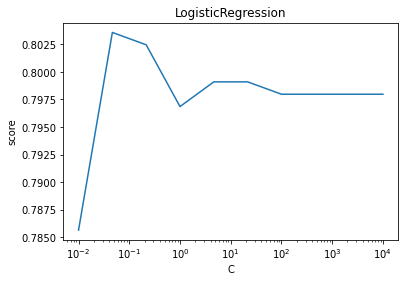

In [119]:
# 画出准确率关于C的变化趋势图
fig=plt.figure
plt.xlabel(r'C')
plt.ylabel(r'score')
plt.xscale('log')
plt.title('LogisticRegression')
plt.plot(Cs,scores)
plt.show()


### K近邻算法(k-NN)

knn算法的**基本法则**是：相同类别的样本之间在特征空间中应当聚集在一起。    

In [99]:
knn=KNeighborsClassifier()
scores = cross_val_score(knn,train_data.iloc[:,1:], train_data['Survived'],cv=cv) # 使用交叉训练 knn模型
print("平均分:{:.4f}".format(scores.mean()))

平均分:0.7980


**调参**

KNN算法我们主要要考虑三个重要的要素，对于固定的训练集，只要这三点确定了，算法的预测方式也就决定了。

这三个最终的要素是**k值的选取**，**距离度量的方式**和**分类决策规则**。

对于分类决策规则，一般都是使用前面提到的多数表决法。

所以我们重点是关注与**k值的选择**和**距离的度量方式**。

In [122]:
Ps=[1,2,100]
k_scores = {}
k_range = range(1,31)
for p in Ps:
    for k in k_range:
        knn = KNeighborsClassifier(n_jobs=2, n_neighbors=k,p=p)
        scores = cross_val_score(knn, train_data.iloc[:,1:], train_data['Survived'],cv=cv,scoring='accuracy')
        k_scores[scores.mean()]=[p,k]
f=k_scores[max(k_scores.keys())]
str='当：\nweight={}\np={}\nn_neighbors={}\n时\n平均准确率最高，为{}'.format(f[0],f[1],f[2],max(k_scores.keys()))
print(str)